#Loading the required packages


In [1]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from yahoo_fin.stock_info import get_data
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

#Exploratory Data Analysis
Initially, we download the relevant dataset from Yahoo Finance, containing historical daily prices and trading volumes of Apple Inc. This dataset spans from five years prior to today (the day of the last run), covering over a thousand trading days. The provided trading information includes Open, High, Low, Close, Adjusted Close prices, and Volume for each trading day.

In [3]:
# Dataset download
today = date.today()
five_years_before = today - relativedelta(years=5)
print(today)
apple_5yr = get_data("aapl", start_date = five_years_before, end_date = today, index_as_date = True, interval="1d")

2023-04-28


In [4]:
apple_5yr

,open,high,low,close,adjclose,volume,ticker
2018-04-30,40.532501,41.814999,40.459999,41.314999,39.386459,169709600,AAPL
2018-05-01,41.602501,42.299999,41.317501,42.275002,40.301651,214277600,AAPL
2018-05-02,43.807499,44.437500,43.450001,44.142502,42.081982,266157600,AAPL
2018-05-03,43.970001,44.375000,43.610001,44.222500,42.158241,136272800,AAPL
2018-05-04,44.562500,46.062500,44.542500,45.957500,43.812248,224805200,AAPL
...,...,...,...,...,...,...,...
2023-04-21,165.050003,166.449997,164.490005,165.020004,165.020004,58311900,AAPL
2023-04-24,165.000000,165.600006,163.889999,165.330002,165.330002,41949600,AAPL
2023-04-25,165.190002,166.309998,163.729996,163.770004,163.770004,48714100,AAPL
2023-04-26,163.059998,165.279999,162.800003,163.759995,163.759995,45498800,AAPL


## Trend of stock price and compared with S&P 500

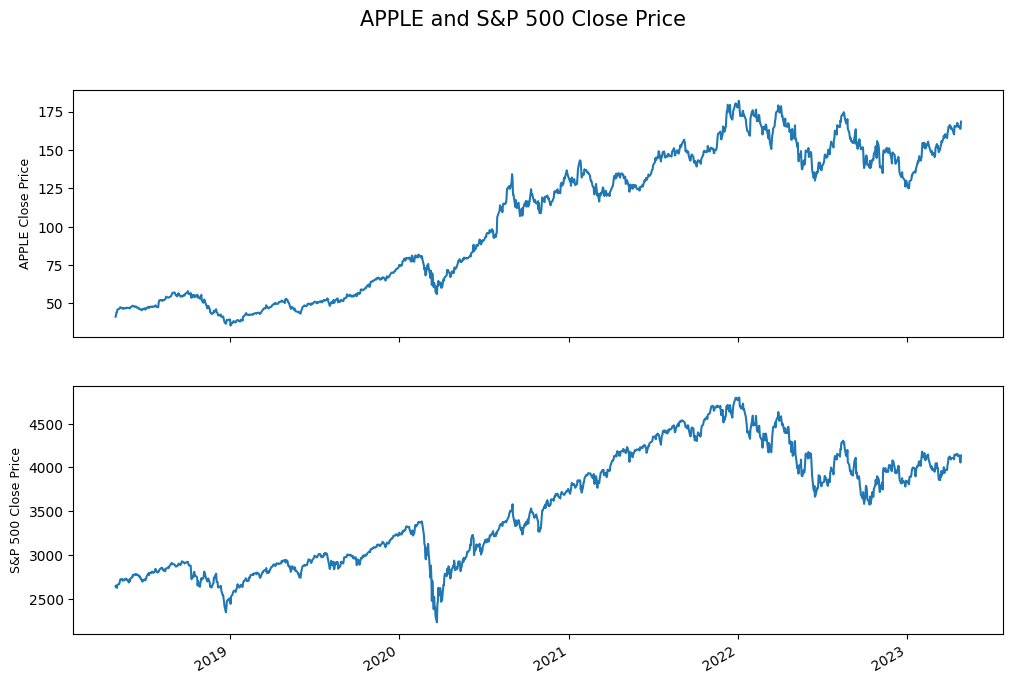

In [5]:
SP_500 = get_data("^GSPC", start_date = five_years_before, end_date = today, index_as_date = True, interval="1d")

fig = plt.figure(figsize=(12,8))
fig.suptitle("APPLE and S&P 500 Close Price", fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(apple_5yr.index,apple_5yr['close'])
ax1.set_ylabel('APPLE Close Price', fontsize=9)

ax2 = fig.add_subplot(212)
ax2.plot(SP_500.index,SP_500['close'])
ax2.set_ylabel('S&P 500 Close Price', fontsize=9)

fig.autofmt_xdate()

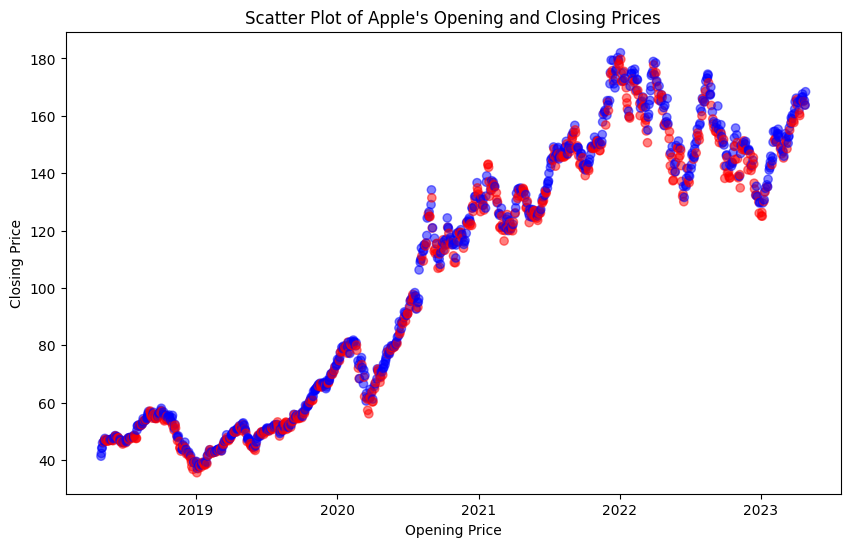

In [6]:
# Generate the scatter plot of opening vs. closing prices
fig, ax = plt.subplots(figsize=(10, 6))
# Create a list of colors for the scatter plot
colors = np.where(apple_5yr['close'] > apple_5yr['open'], 'blue', 'red')
ax.scatter(apple_5yr['open'].index, apple_5yr['close'], c=colors, alpha=0.5)
ax.set_xlabel('Opening Price')
ax.set_ylabel('Closing Price')
ax.set_title('Scatter Plot of Apple\'s Opening and Closing Prices')
plt.show()

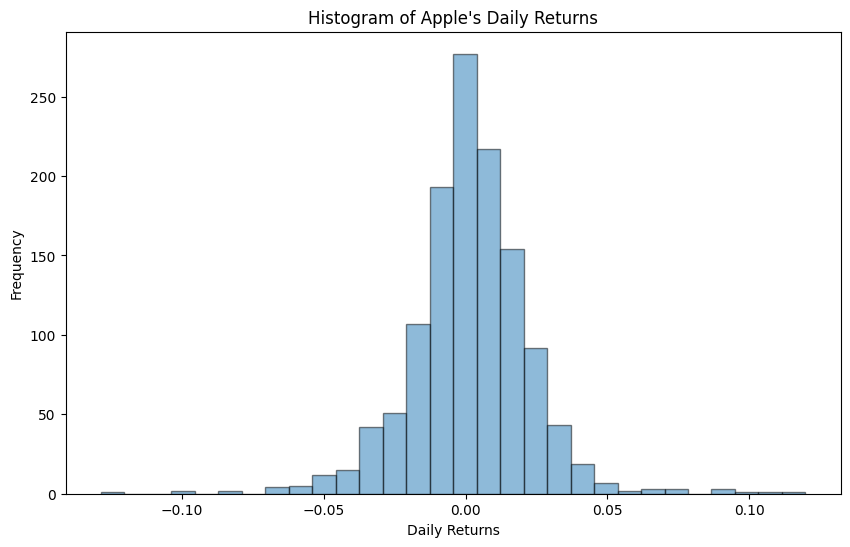

Mean price: 105.04
Standard deviation: 45.72


In [7]:
daily_returns = apple_5yr['close'].pct_change().dropna()
# Generate the histogram of daily returns
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(daily_returns, bins=30, alpha=0.5, edgecolor='black')
ax.set_xlabel('Daily Returns')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Apple\'s Daily Returns')
plt.show()
mean_price = apple_5yr['close'].mean()
std_price = apple_5yr['close'].std()

print(f"Mean price: {mean_price:.2f}")
print(f"Standard deviation: {std_price:.2f}")


Decomposing Time Series Data into Trend and Seasonality

In [8]:
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_add = seasonal_decompose(df[column_name], period=7, model='additive')
    
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))
    result_add.observed.plot(ax=axs[0])
    axs[0].set_title('Observed')

    result_add.trend.plot(ax=axs[1])
    axs[1].set_title('Trend')

    result_add.seasonal.plot(ax=axs[2])
    axs[2].set_title('Seasonal')

    result_add.resid.plot(ax=axs[3])
    axs[3].set_title('Redisual')

    plt.suptitle('Seasonal Decomposition', fontsize=20)
    plt.show()
    
    return result_add

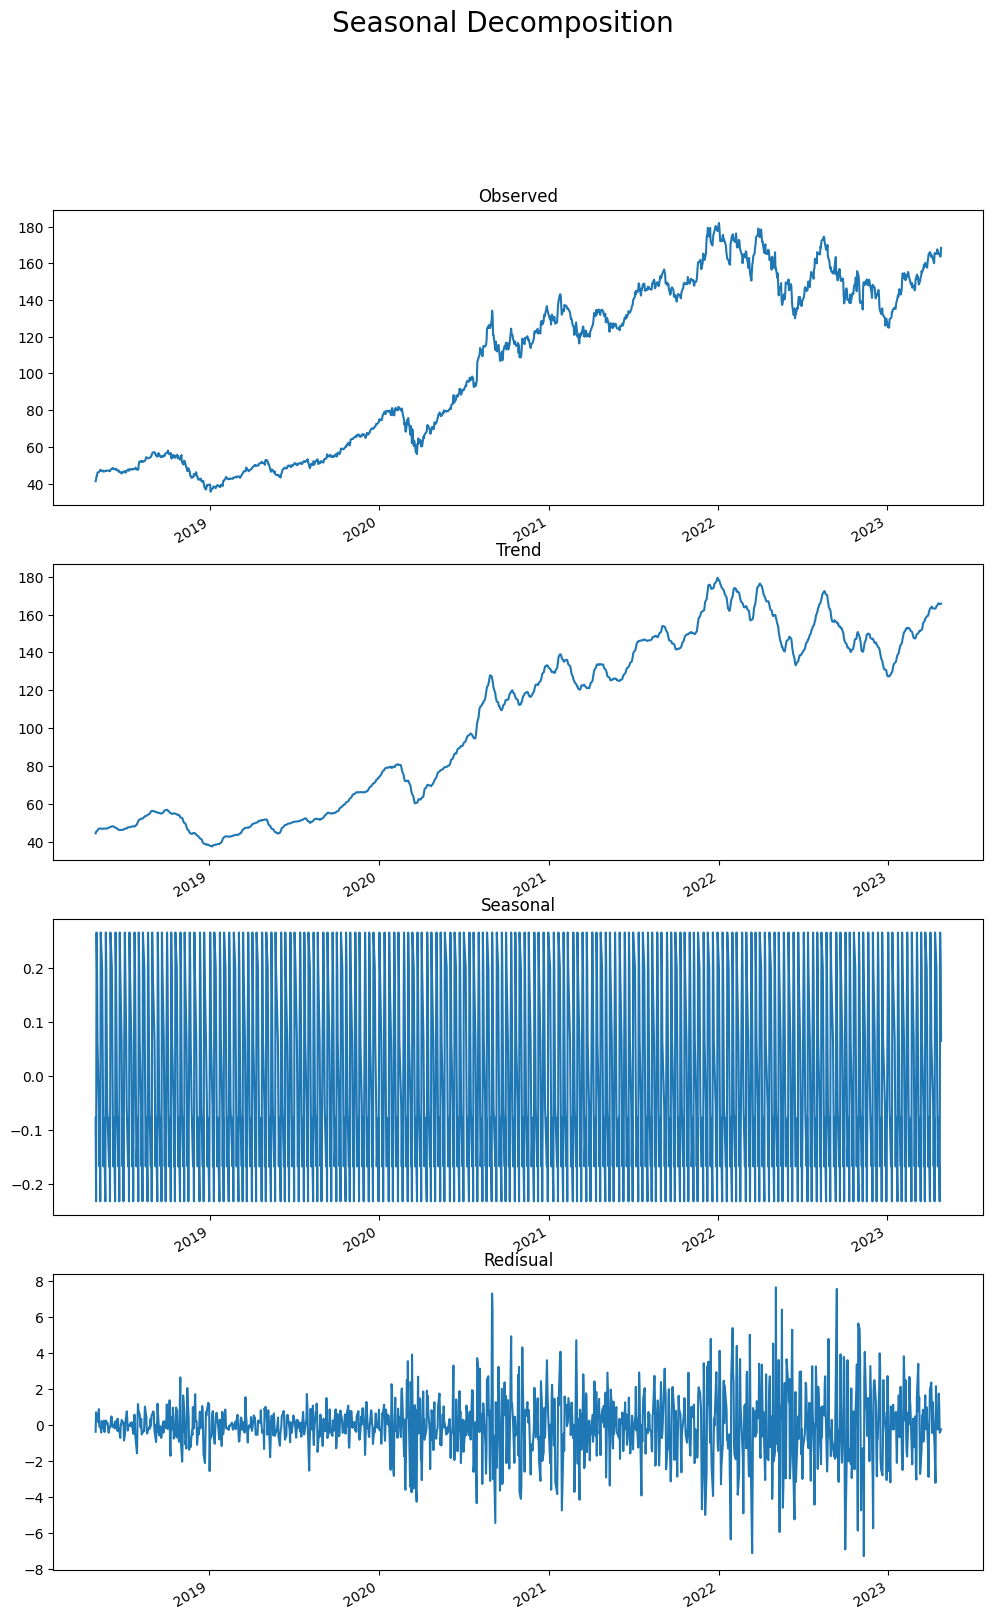

In [9]:
result_add = decompose(apple_5yr, 'close')

In [10]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed.columns = ['seasonal', 'trend', 'resid', 'actual_values']
print(df_reconstructed.head())
print(df_reconstructed.tail())

            seasonal      trend     resid  actual_values
2018-04-30 -0.076740        NaN       NaN      41.314999
2018-05-01 -0.231479        NaN       NaN      42.275002
2018-05-02  0.265726        NaN       NaN      44.142502
2018-05-03  0.200497  44.387858 -0.365855      44.222500
2018-05-04  0.065066  45.177144  0.715291      45.957500
            seasonal       trend     resid  actual_values
2023-04-21 -0.076740  165.518572 -0.421828     165.020004
2023-04-24 -0.231479  165.795715 -0.234235     165.330002
2023-04-25  0.265726         NaN       NaN     163.770004
2023-04-26  0.200497         NaN       NaN     163.759995
2023-04-27  0.065066         NaN       NaN     168.410004


In [11]:
dataset_cl = apple_5yr.close.values
dataset_cl

array([ 41.31499863,  42.27500153,  44.14250183, ..., 163.77000427,
       163.75999451, 168.41000366])

In [12]:
#Time Series Normalization
sc = MinMaxScaler(feature_range = (0, 1))
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

##Cutting our time series into sequences

In [13]:
# Create a function to process the data into 10 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 10)

##Split training and testing sets
To ensure appropriate testing of our dataset, we will allocate the final one-fifth for validation or testing purposes.

Unlike the typical random splitting approach used in validating regression models, we are not employing such a method due to the related nature of our input/output pairs. Validating our model by training on a randomly selected subset and then testing on another random subset would inaccurately simulate receiving new data points within the same timeframe as our training set.

Instead, we will train our model on a continuous segment of the series, specifically the initial four-fifths, and validate it on a subsequent chunk (the final one-fifth). This approach more accurately simulates predicting future values in a time series.

In [14]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)

(997, 10)
(997, 1, 10)


#Time Series Model and Modeling Process
##  Build and run an RNN regression model
After generating input/output pairs from our time series and dividing them into training and testing sets, we can now proceed to construct our RNN using PyTorch. We'll create a multi-layer RNN with the following specifications:

1. An LSTM module with input size of 10, hidden size of 64, 3 layers, dropout rate of 0.1, and configured as unidirectional.
2. A fully connected output layer with one unit.
3. Loss function: Mean Squared Error (MSE)

In [15]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        return outs, hidden_state

In [16]:
learning_rate = 0.001
num_epochs = 400
rnn = RNN(10, 64, 3, 1, bidirectional=False)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hidden_state = None
criterion

MSELoss()

In [17]:
history = []
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
inputs = torch.tensor(X_train).float()
labels = torch.tensor(y_train).float()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs, hidden_state) 
    loss = criterion(output[:,0,:].view(-1), labels)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    rnn.eval()
    test_output, _ = rnn(X_test, hidden_state)
    test_loss = criterion(test_output.view(-1), y_test)
    print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    history.append(loss.item())

epoch 0, loss 0.22158154845237732, eval loss 0.4992334544658661
epoch 1, loss 0.1986304074525833, eval loss 0.4517194628715515
epoch 2, loss 0.17715926468372345, eval loss 0.40393540263175964
epoch 3, loss 0.1567680686712265, eval loss 0.35441771149635315
epoch 4, loss 0.13652144372463226, eval loss 0.30186590552330017
epoch 5, loss 0.11703934520483017, eval loss 0.2452569454908371
epoch 6, loss 0.09806062281131744, eval loss 0.18422779440879822
epoch 7, loss 0.08035441488027573, eval loss 0.12038116157054901
epoch 8, loss 0.06617497652769089, eval loss 0.06054290756583214
epoch 9, loss 0.06070271134376526, eval loss 0.021277669817209244
epoch 10, loss 0.06711827218532562, eval loss 0.011402576230466366
epoch 11, loss 0.07471587508916855, eval loss 0.01088004745543003
epoch 12, loss 0.0710129365324974, eval loss 0.011850970797240734
epoch 13, loss 0.05911485478281975, eval loss 0.01718239113688469
epoch 14, loss 0.048463307321071625, eval loss 0.026960719376802444
epoch 15, loss 0.0410

#Forecasting

In [18]:
train_pred, hidden_state = rnn(inputs, None)
train_pred_ = train_pred.detach().numpy()
# use hidden state from previous training data
test_predict, _ = rnn(X_test, hidden_state)
test_predict_ = test_predict.detach().numpy()

prediction = []
for i in range(int(X.shape[0]*0.20) + 1):
  prediction.append(float(sc.inverse_transform(test_predict_.reshape(-1,1))[i]))
valid = apple_5yr[apple_5yr.shape[0] - 250:]
prediction_df = pd.DataFrame({'Prediction': prediction})

valid = valid.reset_index(drop=False)
valid['Prediction'] = prediction_df['Prediction']
valid = valid.rename(columns={'index': 'Date'})

to_drop = ['open', 'high', 'low', 'adjclose', 'volume', 'ticker']
predict = valid.drop(to_drop, axis='columns')
predict

,Date,close,Prediction
0,2022-04-29,157.649994,166.968338
1,2022-05-02,157.960007,166.114899
2,2022-05-03,159.479996,165.235168
3,2022-05-04,166.020004,164.373505
4,2022-05-05,156.770004,163.561462
...,...,...,...
245,2023-04-21,165.020004,165.597565
246,2023-04-24,165.330002,165.842056
247,2023-04-25,163.770004,166.153458
248,2023-04-26,163.759995,166.469757


In [19]:
# calculate the mean squared error (MSE)
mse = mean_squared_error(predict['close'], prediction)
# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 7.489011022712827


# Model Validation
From the plots below, we found that the model prediction fits the future well.

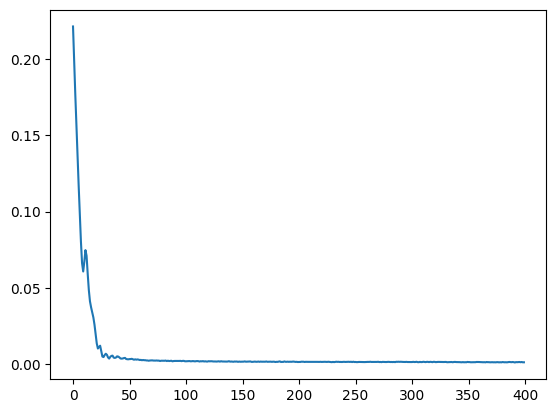

In [20]:
plt.plot(history)

In [21]:
test_predict_.shape

(250, 1, 1)

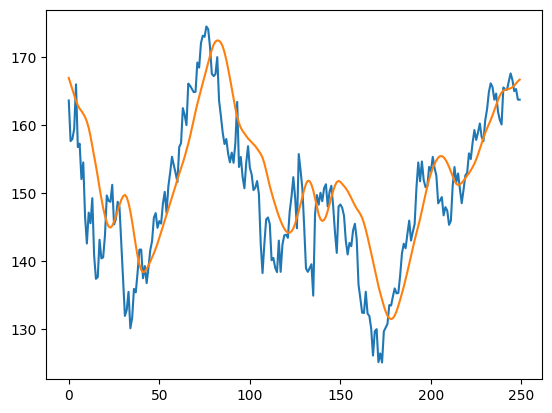

In [22]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_.reshape(-1,1)))

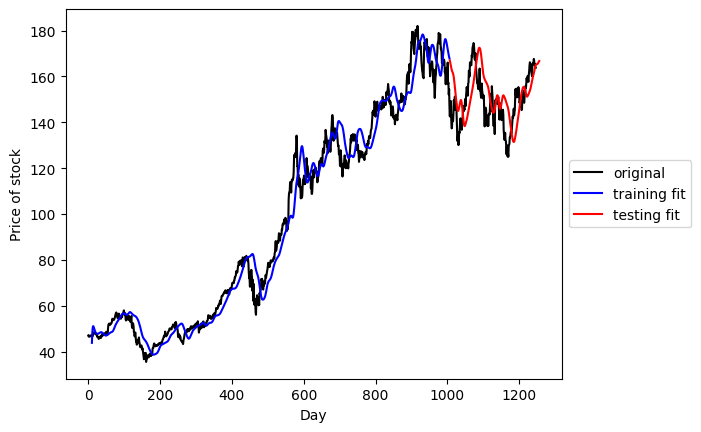

In [23]:
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')
split_pt = int(X.shape[0] * 0.80) + 10
plt.plot(np.arange(10, split_pt, 1), sc.inverse_transform(train_pred_.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_), 1), sc.inverse_transform(test_predict_.reshape(-1,1)), color='r')
plt.xlabel('Day')
plt.ylabel('Price of stock')
plt.legend(['original','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()